We spotted that the strings in the first column could be split into usefull data. We transformed that data to at% using the formula under : 



$\text{at\% of element} = \frac{\sum_{i=1}^{n} (n_i \times M_i)}{n_{\text{element}} \times M_{\text{element}}} \times 100$




In [14]:
# Define the molar fractions and atomic weights of each element in the composition
import pandas as pd

def parse_composition_string(composition_string):
    elements = []
    values = []
    temp = ''
    i = 0
    while i < len(composition_string):
        if composition_string[i].isalpha():
            if i + 1 < len(composition_string) and composition_string[i + 1].islower():
                elements.append(composition_string[i:i + 2].lower())
                i += 2
            else:
                elements.append(composition_string[i].lower())
                i += 1
            if temp:
                values.append(temp)
                temp = ''
        else:
            temp += composition_string[i]
            i += 1
    if temp:
        values.append(temp)

    molar_fractions = {elements[i]: float(values[i]) for i in range(len(elements))}

    # Atomic weights (g/mol)
    atomic_weights = {
        'fe': 55.845,
        'c': 12.011,
        'mn': 54.938,
        'si': 28.085,
        'cr': 51.996,
        'ni': 58.693,
        'mo': 95.95,
        'v': 50.942,
        'n': 14.007,
        'nb': 92.906,
        'co': 58.933,
        'w': 183.84,
        'al': 26.982,
        'ti': 47.867
    }

    # Calculate the molar mass of the mixture
    total_molar_mass = sum(molar_fractions[element] * atomic_weights[element] for element in molar_fractions)

    # Calculate weight percentage for each element
    weight_percentages = {
        element: (molar_fractions[element] * atomic_weights[element] / total_molar_mass) * 100
        for element in molar_fractions
    }

    # Create a DataFrame with the composition string and weight percentages
    data = {'Composition String': [composition_string]}
    data.update({element: [weight_percentages[element]] for element in weight_percentages})
    df_weight_percentages = pd.DataFrame(data)
    # # drop the column "Fe"
    # df_weight_percentages = df_weight_percentages.drop(columns=['fe'])

    return df_weight_percentages


we merged the data found above and the original data by overlaying them :

In [53]:
# rename the first column to "formula"
# df = df.rename(columns={'Composition String': 'formula'})
# read a xlsx file
df = pd.read_csv('database_steel_properties (1).csv')


all_weight_percentages = pd.DataFrame()

# Iterate through each composition string in the DataFrame
for string in df['formula']:
    df_weight_percentages = parse_composition_string(string)
    all_weight_percentages = pd.concat([all_weight_percentages, df_weight_percentages], ignore_index=True)

# rearrange the columns as follow : Composition String, c,	mn	,si	,cr	,ni	,mo	,v	,n	,nb	,co	,w	,al	,ti
all_weight_percentages = all_weight_percentages[['Composition String', 'fe','c', 'mn', 'si', 'cr', 'ni', 'mo', 'v', 'n', 'nb', 'co', 'w', 'al', 'ti']]
all_weight_percentages = all_weight_percentages.rename(columns={'Composition String': 'formula'})

all_weight_percentages.to_excel('weight_percentages.xlsx', index=False)

# Read the original file and the new file
df2 = pd.read_excel('weight_percentages.xlsx')

# Merge the dataframes on 'formula' while prioritizing original file
df3 = df.merge(df2, on='formula', how='left', suffixes=('', '_new'))

# Fill in missing values in the original dataframe with corresponding values from df2
for col in df3.columns:
    if col.endswith('_new'):  # Handle columns from the new file
        original_col = col.replace('_new', '')
        if original_col in df3.columns:  # Fill original column if it exists
            df3[original_col] = df3[original_col].fillna(df3[col])
        else:  # If no matching original column, rename the new column
            df3.rename(columns={col: original_col}, inplace=True)

# Drop '_new' columns if not needed
df3 = df3[[col for col in df3.columns if not col.endswith('_new')]]

df3 = df3[['formula', 'fe','c', 'mn', 'si', 'cr', 'ni', 'mo', 'v', 'n', 'nb', 'co', 'w', 'al', 'ti']]


# Save the result to a new Excel file
df3.to_excel('merged_file.xlsx', index=False)


We add back the mechanical properties to the file and we have spotted that the row 263 had a NaN value for 'w' we thus remove it. 


In [54]:
df4 = pd.read_excel('merged_file.xlsx')
df5 = pd.read_csv('database_steel_properties (1).csv')
mech_properties = ['yield strength', 'tensile strength', 'elongation']

# Merge the dataframes on formula
df_merged = pd.merge(df4, df5[['formula'] + mech_properties], on='formula', how='left')
df4_selected = df_merged[['formula', 'fe', 'c', 'mn', 'si', 'cr', 'ni', 'mo', 'v', 'n', 'nb', 'co', 'w', 'al', 'ti'] + mech_properties]

# remove line with that formula : "Fe0.788Mn0.000104Si0.000203Cr0.000109Ni0.176Mo0.0184V0.000112Nb0.0000613Co0.0000966Al0.00105Ti0.0166"
df4_selected = df4_selected[df4_selected['formula'] != 'Fe0.788Mn0.000104Si0.000203Cr0.000109Ni0.176Mo0.0184V0.000112Nb0.0000613Co0.0000966Al0.00105Ti0.0166']
# Save the result to merged_file.xlsx
df4_selected.to_excel('merged_file.xlsx', index=False)


Then we used a z-scoring method to normalize data for it to be clean when we'll be doing machine learning with it. Note that We have manually added the mechanical properties of the samples on excel. 

In [55]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

# path_vlad = r"C:\Users\vladimir jurien\OneDrive - Imperial College London\Imperial\Y2\Steel Challenge\Challenge-2024-2025\Comp\\"
# path_damaso = '/Users/damasomatheus/Desktop/Damaso\'s Stuff/Imperial/Materials/Year 2/MATE50001/coding challenge 24/Challenge-2024-2025/Comp/'
# who = input('Who are you? ')
# if who == 'vlad':
#     path = path_vlad
    
# else:
#     path = path_damaso

data = pd.read_excel("merged_file.xlsx").copy()
inputs = data[['fe', 'c', 'mn', 'si', 'cr', 'ni', 'mo', 'v', 'n', 'nb', 'co', 'w', 'al', 'ti']]
scaler = StandardScaler()
normalized_inputs = scaler.fit_transform(inputs)
data[['fe', 'c', 'mn', 'si', 'cr', 'ni', 'mo', 'v', 'n', 'nb', 'co', 'w', 'al', 'ti']] = normalized_inputs
data.to_excel('normalized_file_complete.xlsx', index=False)



So the data is now normalized but we still miss the values for the mechanical properties.  
The first idea was to fill the blanks using basic methods such as means or median values. But as we had some time in front of us we decided to predict the values using the preprocessed data and the following methods:  
- Euclidean distance:  
    $ \text{Euclidean distance} = \sqrt{\sum_{i=1}^{n} (x_i)^2} $  
- K-nearest neighbor.
This step was made with the use of AI, but a deep understanding of knn was made using lecture notes and the following website : https://arize.com/blog-course/knn-algorithm-k-nearest-neighbor/#:~:text=KNN%20works%20in%20three%20main,value%20of%20the%20neighbors%2C%20respectively.

In [56]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.impute import SimpleImputer
# path = r"C:\Users\vladimir jurien\OneDrive - Imperial College London\Imperial\Y2\Steel Challenge\Challenge-2024-2025\Comp\\"

# Here we dont consider 
comp_columns = ['fe','c','mn', 'si', 'cr', 'ni', 'mo', 'v', 'n', 'nb', 'co', 'w', 'al', 'ti']

# Identify mechanical properties
mech_properties = ['yield strength', 'tensile strength', 'elongation']

data =pd.read_excel( 'normalized_file_complete.xlsx')

# Function to impute missing values using k-nearest neighbors
def impute_with_knn(df, k=5):
    
    # Create a copy of the dataframe
    imputed_df = df.copy()
    
    
    # Separate compositional and mechanical data
    comp_data = df[comp_columns]
    mech_data = df[mech_properties]
    
    # Calculate Euclidean distances between compositional vectors
    distances = euclidean_distances(comp_data)
    
    # Impute each mechanical property
    for prop in mech_properties:
        # Find rows with missing values for this property
        missing_mask = mech_data[prop].isna()
        
        if missing_mask.any():
            # For each row with missing value
            for idx in mech_data[missing_mask].index:
                # Find k nearest neighbors, excluding the current row itself
                distances_to_current = distances[idx].copy()
                distances_to_current[idx] = np.inf  # Exclude self
                
                # Get indices of k nearest neighbors
                k_nearest_indices = np.argsort(distances_to_current)[:k]
                
                # Get the values of the property for these neighbors
                neighbor_values = mech_data.loc[k_nearest_indices, prop]
                neighbor_values = neighbor_values[~neighbor_values.isna()]
                
                # Impute with weighted average (closer neighbors have higher weight)
                if len(neighbor_values) > 0:
                    # Weights inversely proportional to distance
                    weights = 1 / distances_to_current[k_nearest_indices[:len(neighbor_values)]]
                    weights = weights / weights.sum()
                    
                    imputed_value = np.average(neighbor_values, weights=weights)
                    imputed_df.loc[idx, prop] = imputed_value
    
    return imputed_df

# Perform imputation we choose k=5 here but it can be changed
imputed_data = impute_with_knn(data, k=5)

# Print summary of imputation
print("Original missing values:")
print(data[mech_properties].isna().sum())
print("\nImputed missing values:")
print(imputed_data[mech_properties].isna().sum())

# Optional: Save imputed dataset
imputed_data.to_excel('imputed_materials_data.xlsx', index=False)



Original missing values:
yield strength       4
tensile strength     5
elongation          13
dtype: int64

Imputed missing values:
yield strength      0
tensile strength    0
elongation          6
dtype: int64


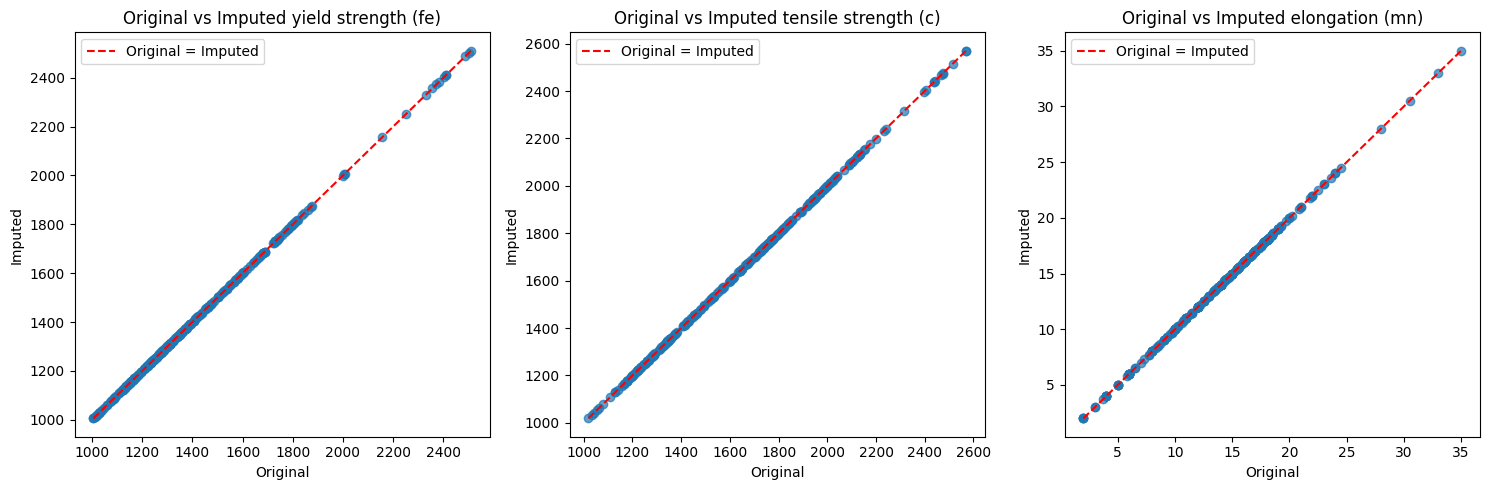


Imputation Validation:

yield strength:
Original Mean: 1415.63
Imputed Mean: 1420.20
Original Std Dev: 297.93
Imputed Std Dev: 302.12

tensile strength:
Original Mean: 1640.90
Imputed Mean: 1642.72
Original Std Dev: 346.91
Imputed Std Dev: 346.21

elongation:
Original Mean: 14.04
Imputed Mean: 14.07
Original Std Dev: 5.10
Imputed Std Dev: 5.07


In [57]:
# Visualization of imputation results
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
for i, prop in enumerate(mech_properties):
    plt.subplot(1, 3, i+1)
    plt.scatter(data[prop], imputed_data[prop], alpha=0.7)
    plt.plot([data[prop].min(), data[prop].max()], 
             [data[prop].min(), data[prop].max()], 
             'r--', label='Original = Imputed')
    plt.title(f'Original vs Imputed {prop} ({comp_columns[i]})')
    plt.xlabel('Original')
    plt.ylabel('Imputed')
    plt.legend()

plt.tight_layout()
plt.show()

# Additional validation
def validate_imputation(original, imputed):
    print("\nImputation Validation:")
    for prop in mech_properties:
        original_mean = original[prop].mean()
        imputed_mean = imputed[prop].mean()
        original_std = original[prop].std()
        imputed_std = imputed[prop].std()
        
        print(f"\n{prop}:")
        print(f"Original Mean: {original_mean:.2f}")
        print(f"Imputed Mean: {imputed_mean:.2f}")
        print(f"Original Std Dev: {original_std:.2f}")
        print(f"Imputed Std Dev: {imputed_std:.2f}")

validate_imputation(data, imputed_data)

Then we labelled the values as fragile, medium, solid

In [58]:

data = pd.read_excel("imputed_materials_data.xlsx").copy()
#function to classify elongation into categories: fragile, medium and strong
def classify_strength(elongation):
    if elongation < 5:
        return "Fragile"
    elif 5 <= elongation <= 10:
        return "Medium"
    elif elongation > 10 :
        return "Strong"
    else:
        return "Unknown"

data['strength_rating'] = data['elongation'].apply(classify_strength)

output_file = "final_steel_data.xlsx"
data.to_excel(output_file, index=False)
